# **Figure 4.** Machs
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 4/20/2022|

## Turbulent Gas Mach Numbers

AB/0.05
  Ma_x = 1.1e-02 ± 3.1e-04
  Ma_z = 7.3e-03 ± 2.0e-04
BA/0.05
  Ma_x = 1.1e-02 ± 1.0e-03
  Ma_z = 3.2e-02 ± 7.5e-03


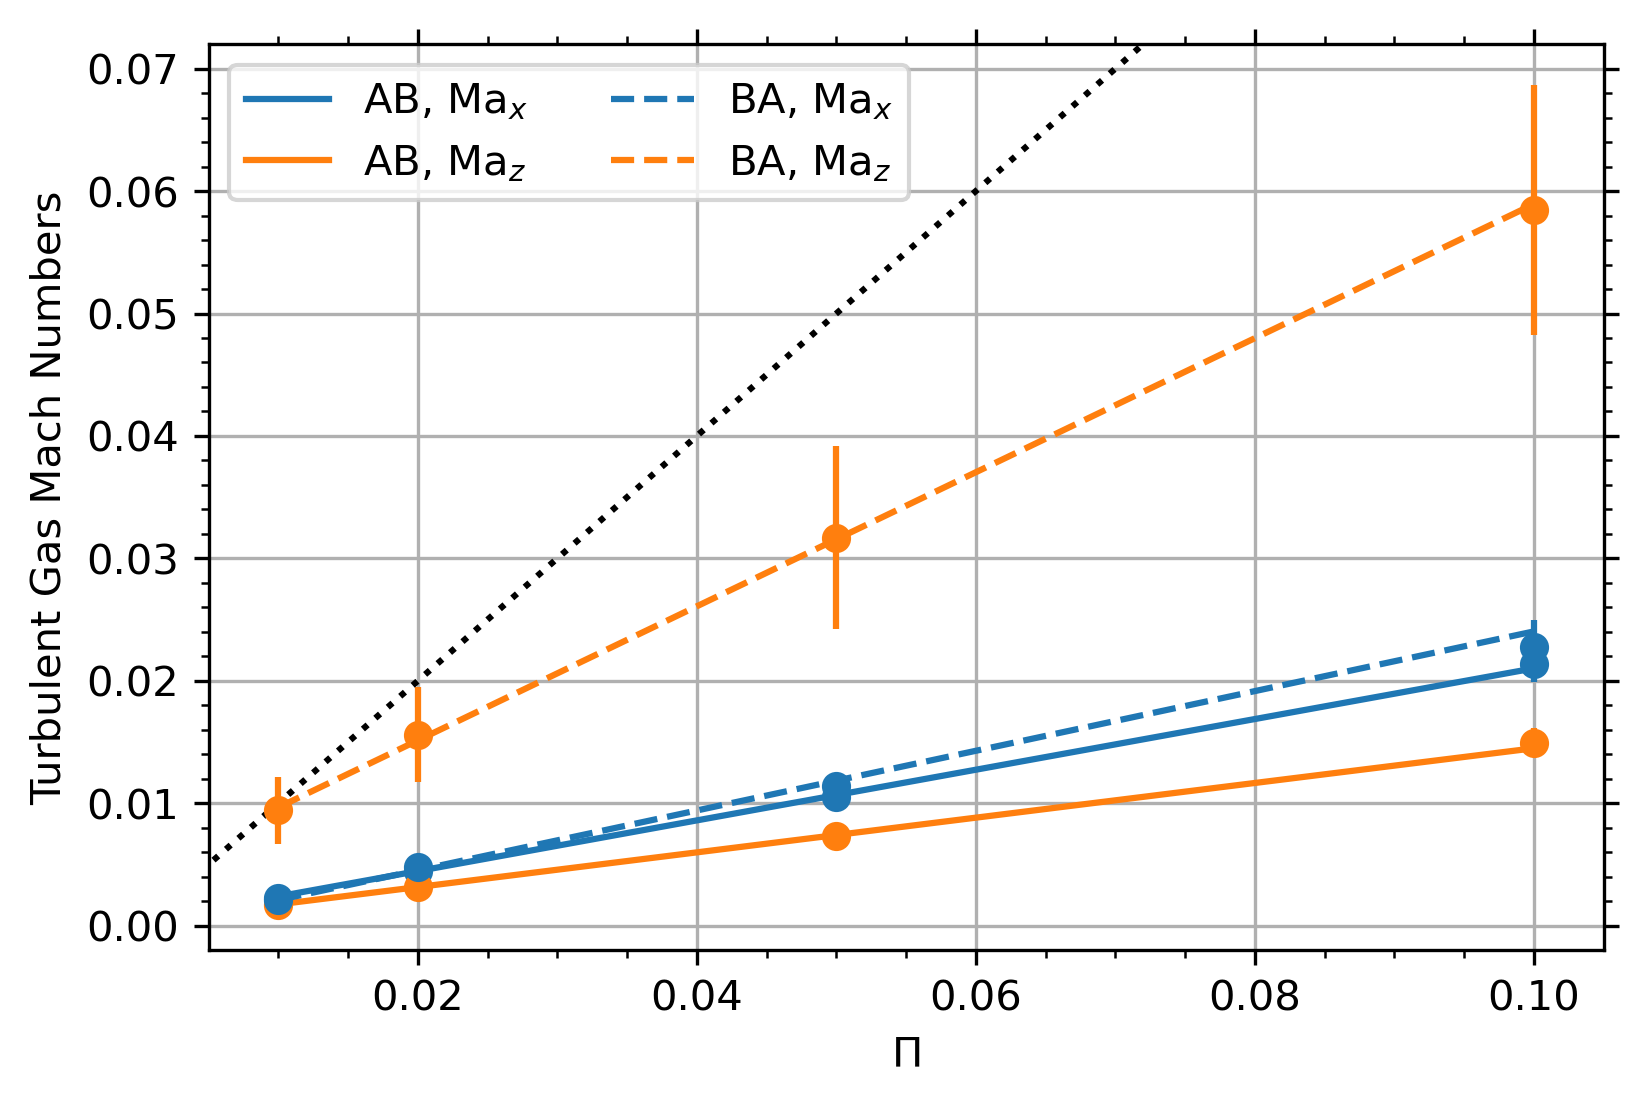

In [5]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

dpi = 300 # PDF resolution (dots per inch)
pwd = '../unstrat/'

fig, ax = plt.subplots(dpi=dpi)
runs = [['AB', 'solid', 2.0], ['BA', 'dashed', 20.0]]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'tab:blue'],
        ['z', '2-mom', '2-KE', 2, 'tab:orange']]
avgMas, stdMas= np.zeros((len(Pis), len(dirs))), np.zeros((len(Pis), len(dirs)))
func = lambda x, b, m : m*x+b # linear model function
case, modfunc, b, berr, m, merr = [], [], [], [], [], []

for run in runs:
    print(f'{run[0]:s}/0.05')
    for i,dir in enumerate(dirs):
        for j,Pi in enumerate(Pis):
            path = pwd+'%s/%s/%s/'%(run[0], f'{Pi:0.2f}', res)
            athinput = athena_read.athinput(path+'athinput.si')
            hst = athena_read.hst(path+'output/SI.hst')
            i_sat = int(run[2]/athinput['output3']['dt']) # index of sat. state
            disp = np.sqrt(dir[3]*hst[dir[2]]/hst['mass']-(hst[dir[1]]/hst['mass'])**2)
            Ma = disp/athinput['hydro']['iso_sound_speed']
            avgMas[j,i], stdMas[j,i] = np.average(Ma[i_sat:]), np.std(Ma[i_sat:])
            if Pi==0.05:
                print(f'  Ma_{dir[0]:s} = {avgMas[j,i]:.1e} ± {stdMas[j,i]:.1e}')

        popt, pcov = curve_fit(func, Pis, avgMas[:,i], sigma=stdMas[:,i])
        perr = np.sqrt(np.diag(pcov))
        label = r'{:s}, Ma$_{:s}$'.format(run[0], dir[0])
        
        ax.errorbar(Pis, avgMas[:,i], stdMas[:,i], fmt='o', color=dir[4])
        ax.plot(Pis, func(np.asarray(Pis), *popt), ls=run[1], color=dir[4], label=label)
        case.append(run[0]); modfunc.append(f'Ma$_{dir[0]:s}=m\Pi+b$')
        b.append(popt[0]); berr.append(perr[0])
        m.append(popt[1]); merr.append(perr[1])

# ax.plot([0.01, 0.07], [0.01, 0.07], ls=':', color='black')
ax.plot([0.0, 0.11], [0.0, 0.11], ls=':', color='black')
ax.grid()
ax.legend(ncol=2)
ax.minorticks_on()
ax.set(xlabel=r'$\Pi$', ylabel='Turbulent Gas Mach Numbers', xlim=(0.005, 0.105), ylim=(-0.002,0.072))
ax.tick_params(which='both', top=True, right=True)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('figs/machs.png', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case'       : case,
    'Function'   : modfunc,
    '$m$'        : m,
    '$\pm\sigma_m$' : merr,
    '$b$'        : b,
    '$\pm\sigma_b$' : berr,})
s = df.style.format({
    '$m$'        : '{:.2f}',
    '$\pm\sigma_m$' : '$\pm${:.3f}',
    '$b$'        : '{:.1e}',
    '$\pm\sigma_b$' : '$\pm${:.1e}',})
s.to_latex(buf='tabs/machs.txt')